In [58]:
import os
import warnings
import joblib
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed 
from sklearn import ensemble, linear_model, svm
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from lazy_test import *
from success_utils import *
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

domain_post_data =  pd.read_csv(f'/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Data/final_datasets/domain_post.csv')
domain_engagement_data =  pd.read_csv(f'/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Data/final_datasets/domain_engagement.csv')
domain_only_data =  pd.read_csv(f'/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Data/final_datasets/domain_only.csv')

target_cols = ['success', 'num_backers', 'collection_ratio']

## Domain_post

In [59]:
x_train, x_test, y_train, y_test = train_test_split(domain_only_data.drop(target_cols, axis=1), domain_only_data[target_cols], test_size=0.2, random_state=42, stratify=domain_only_data.success)

x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [60]:
model_folder = '/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Modelling/final_models/04_domain_only'
os.listdir(model_folder)

['num_backers.pkl', 'collection_ratio.pkl', 'success.pkl']

In [61]:
success_model = joblib.load(f'{model_folder}/success.pkl')
backers_model = joblib.load(f'{model_folder}/num_backers.pkl')
collection_model = joblib.load(f'{model_folder}/collection_ratio.pkl')

In [62]:
def get_importance(model, test_inputs, test_outputs):
    importance = permutation_importance(
            model,
            test_inputs,
            test_outputs.values,
            n_repeats=25,
            random_state=42,
            n_jobs=-1
        )
    return importance

def plot_importance(importance, columns, save_dir):
    importance_df= pd.DataFrame(
            data=importance.importances_mean,
            index=columns,
            columns=['Importance']
        ).sort_values(by='Importance', ascending=False)
    
    importance_df.Importance = (importance_df.Importance - importance_df.Importance.min())/ (importance_df.Importance.max() - importance_df.Importance.min())
    
    importance_df.plot(kind='bar', figsize=(20,10))
    plt.title('Permutation Importance')
    plt.ylabel('Importance')
    
    plt.savefig(save_dir+'feature_importance.png')

    return importance_df

Success Done!
Success Done!
Success Done!


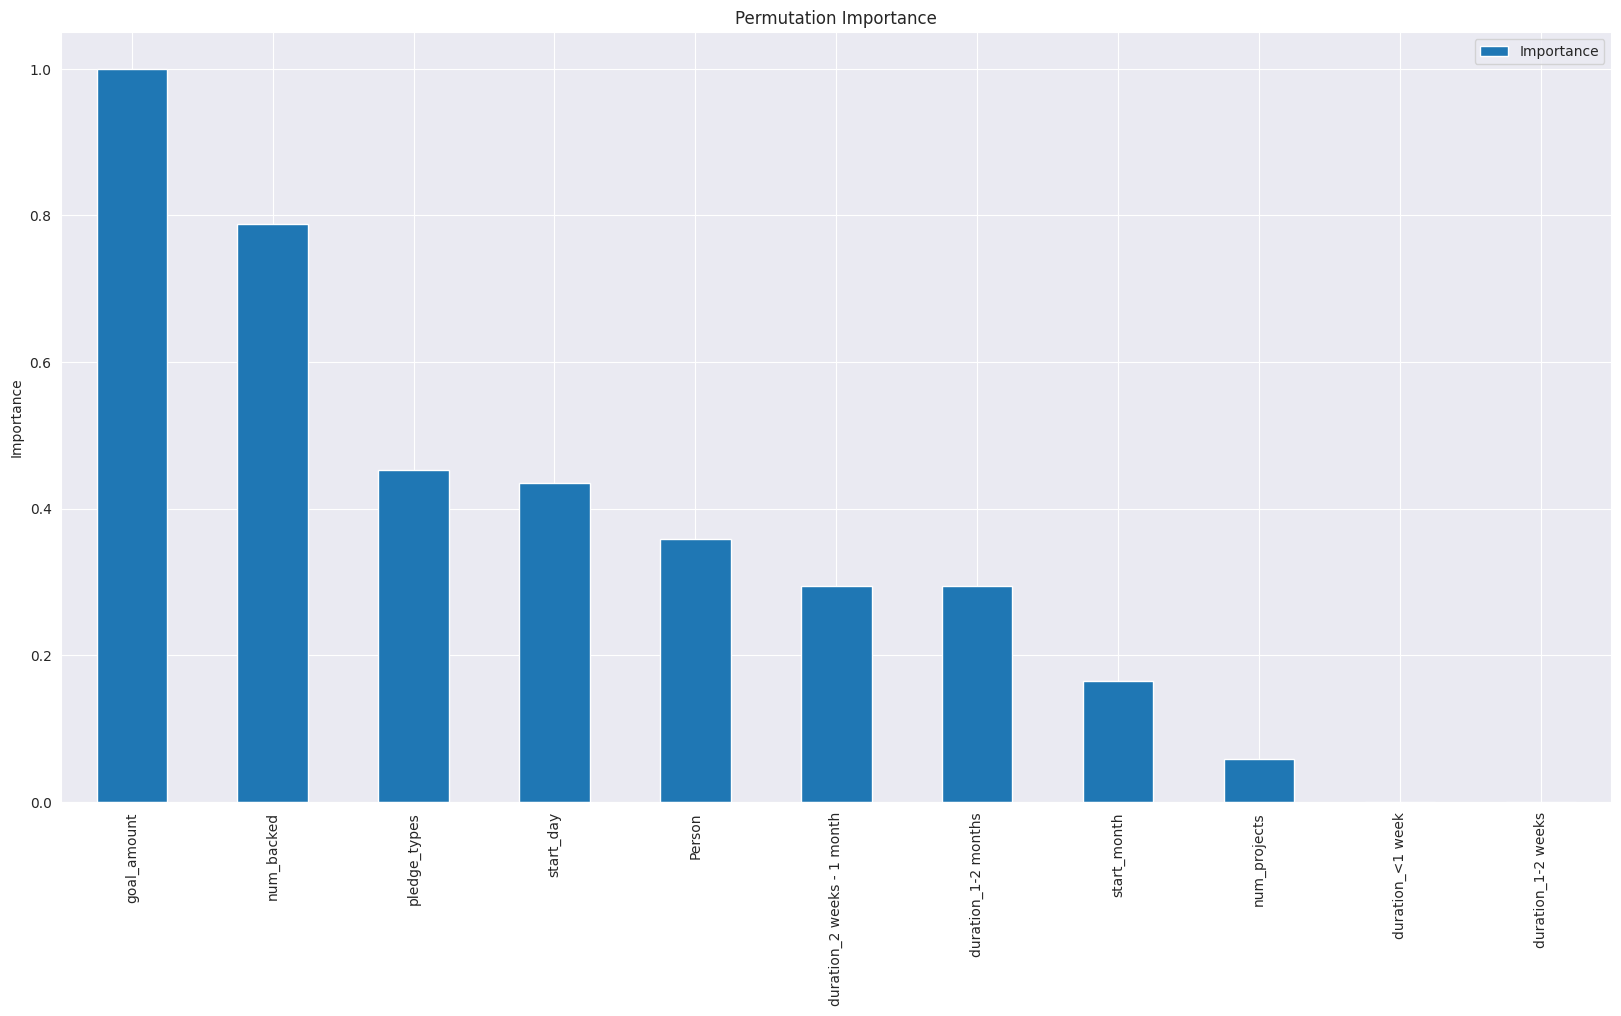

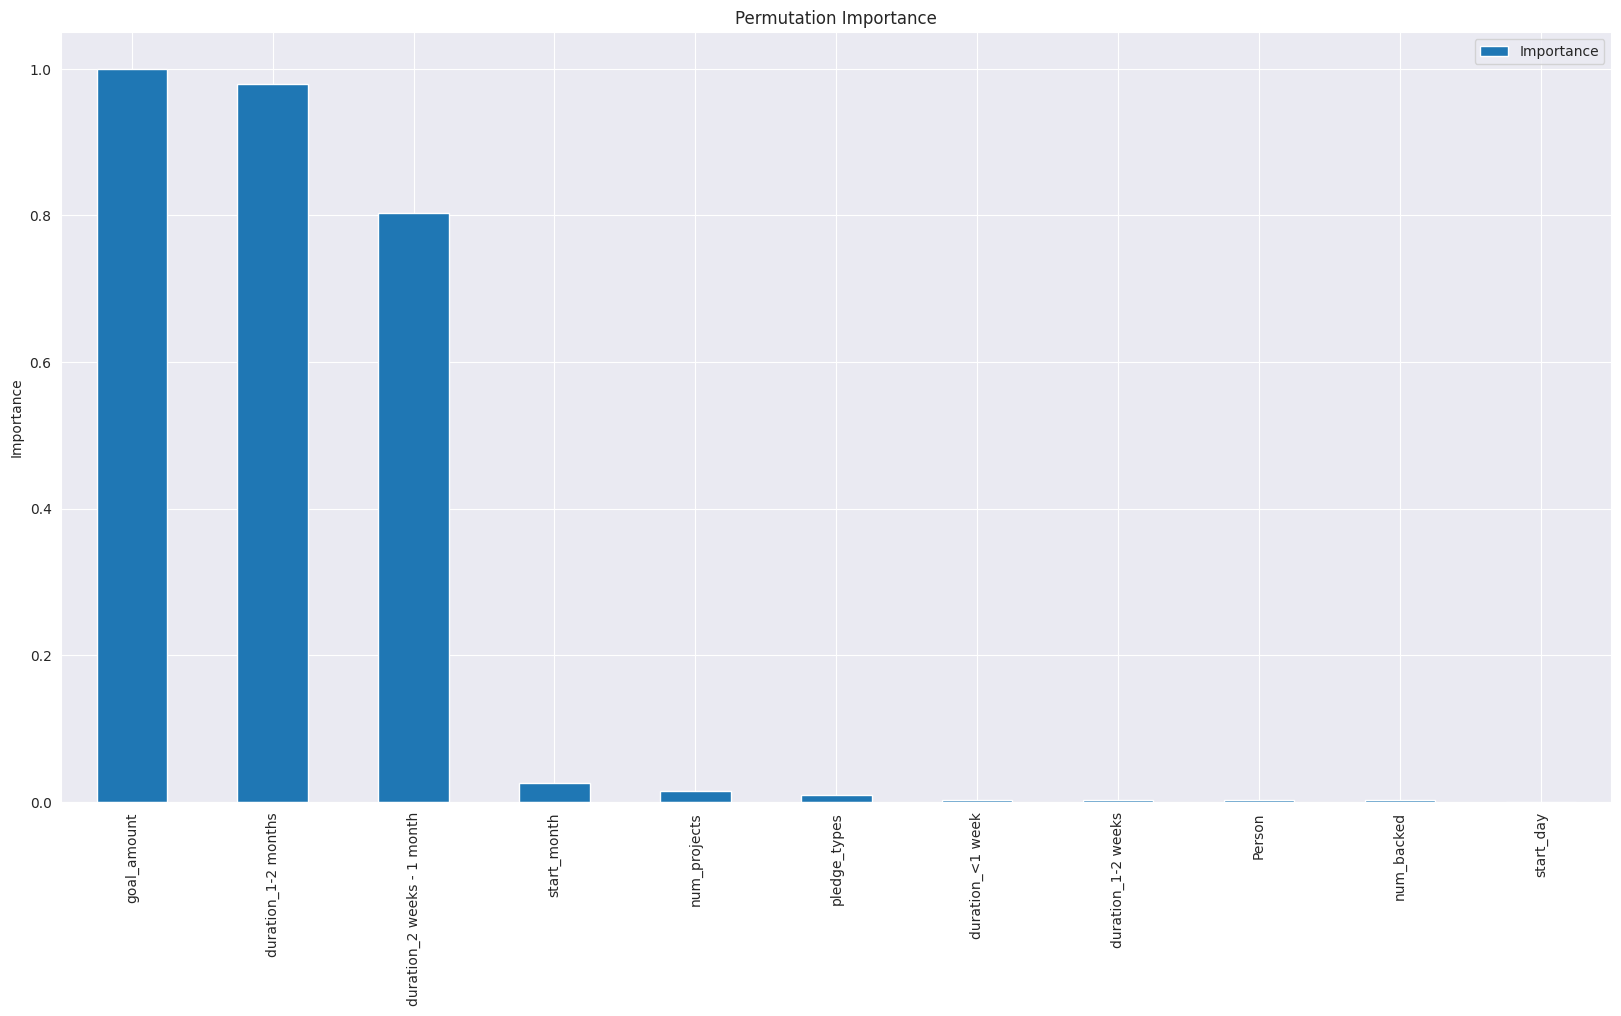

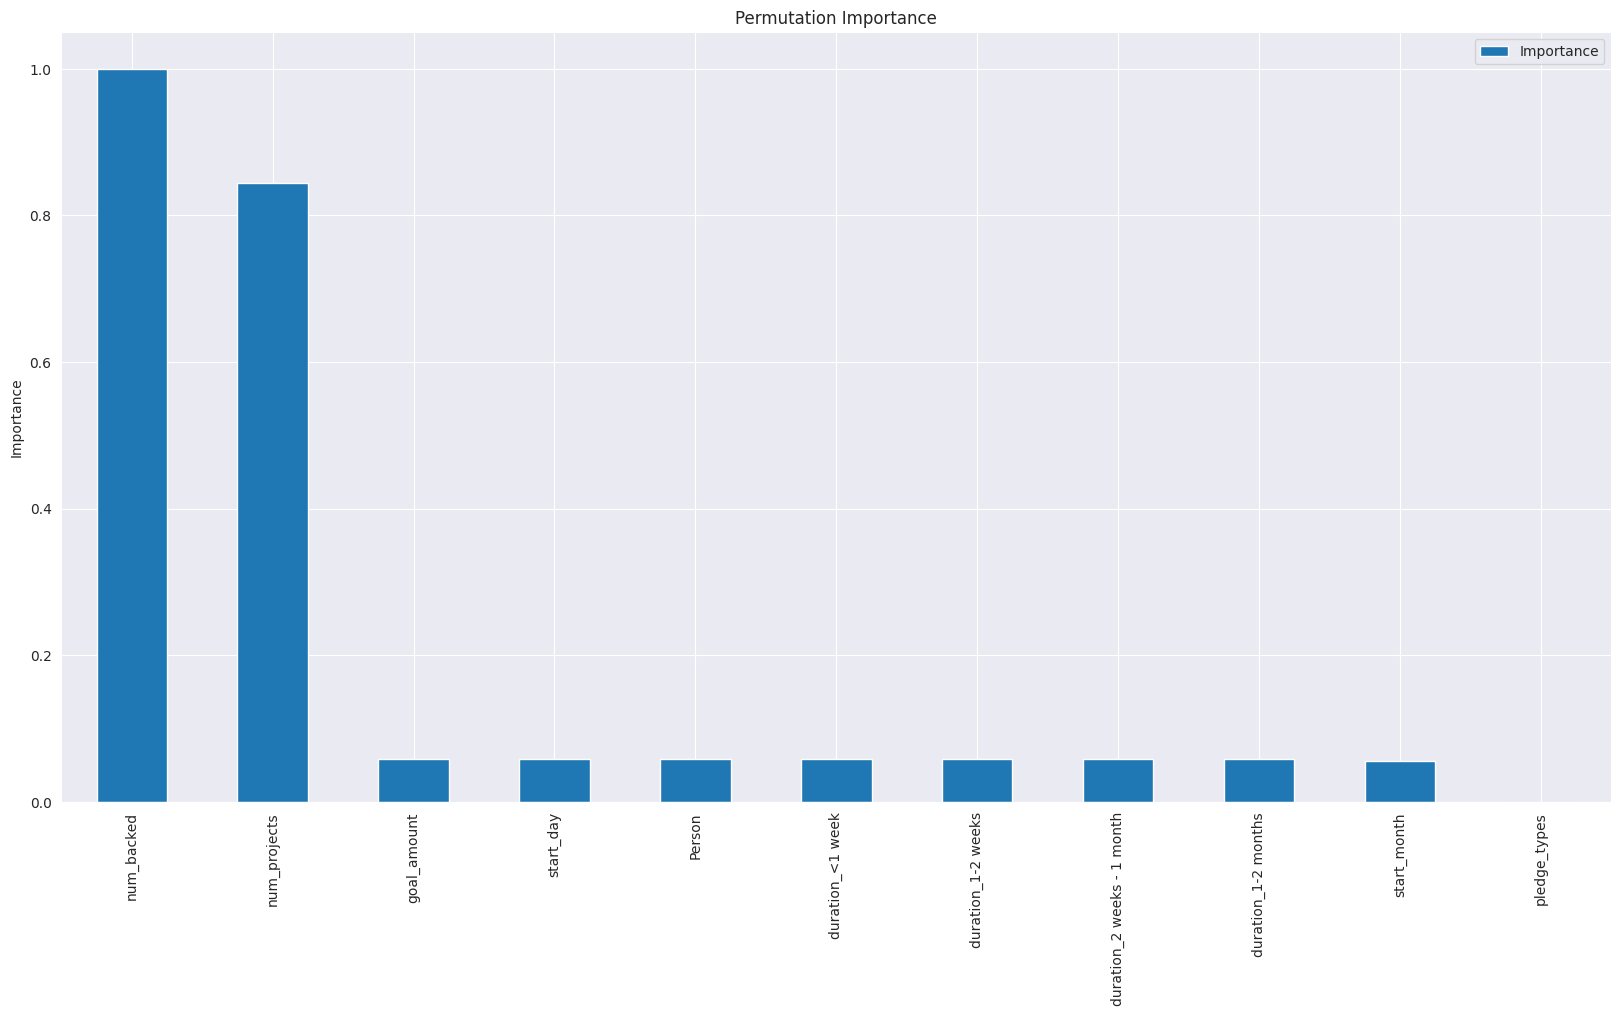

In [63]:
importance_df_dict = {
    'success': None,
    'backers': None,
    'collection_ratio': None
}


for i in ['success', 'backers', 'collection_ratio']:
    save_dir = '/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Results/04 - Domain Only'
    if i == 'success':
        model = success_model
        test_outputs = y_test.success
        save_dir = f'{save_dir}/success/'
    elif i == 'backers':
        model = backers_model
        test_outputs = y_test.num_backers
        save_dir = f'{save_dir}/num_backers/'
    elif i == 'collection_ratio':
        model = collection_model
        test_outputs = y_test.collection_ratio
        save_dir = f'{save_dir}/collection_ratio/'
    

    importance = get_importance(model, x_test.values, test_outputs)
    importance_df = plot_importance(importance, x_test.columns, save_dir)
    
    importance_df_dict[i] = importance_df

    print('Success Done!')


In [64]:
for key in importance_df_dict.keys():
    print(key)
    importance_df_dict[key].to_csv(f'/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Results/04 - Domain Only/{key}_importance.csv')
    print(f'{key} Done!')

success
success Done!
backers
backers Done!
collection_ratio
collection_ratio Done!


In [65]:
importance_df_dict['backers'].shape

(11, 1)

In [67]:
imp_cat_features = {
    'backers': ['start_day', 'start_month', 'duration_<1 week', 'duration_1-2 weeks', 'duration_1-2 months',
                # 'fb_entity_ORG','fb_entity_PERSON','fb_entity_DATE','fb_entity_CARDINAL',
                # 'fb_entity_GPE','fb_entity_PRODUCT','fb_entity_WORK_OF_ART',
                # 'fb_entity_ORDINAL','fb_entity_MONEY','fb_entity_TIME','fb_entity_NORP'
                ],
    'success': [ 'start_day', 'duration_<1 week',
                 'duration_1-2 weeks', 'duration_2 weeks - 1 month',
                 'duration_1-2 months', 'Person', 'start_month',
                 # 'fb_entity_ORG','fb_entity_PERSON','fb_entity_DATE','fb_entity_CARDINAL',
                 # 'fb_entity_GPE','fb_entity_PRODUCT','fb_entity_WORK_OF_ART',
                 # 'fb_entity_ORDINAL','fb_entity_MONEY','fb_entity_TIME','fb_entity_NORP'
                 ],
    'collection_ratio': ['start_day', 'duration_<1 week', 'duration_1-2 weeks', 'Person', 'duration_2 weeks - 1 month', 'duration_1-2 months',
                        #  'fb_entity_ORG','fb_entity_PERSON','fb_entity_DATE','fb_entity_CARDINAL',
                        # 'fb_entity_GPE','fb_entity_PRODUCT','fb_entity_WORK_OF_ART',
                        # 'fb_entity_ORDINAL','fb_entity_MONEY','fb_entity_TIME','fb_entity_NORP'
    ]
}

In [68]:
def get_partial_dependence_plot(model, features, x, y, feature_name, categirical_features=None):
    n_features = len(features)
    n_cols = n_features//3
    n_rows = np.ceil(n_features / n_cols)

    fig, axs = plt.subplots(int(n_rows), n_cols, figsize=(15, 20))
    
    axs = axs.ravel()  # Flatten the array of axes

    PartialDependenceDisplay.from_estimator(
    model,
    x,
    features=features,
    categorical_features=categirical_features,
    target=y,
    n_jobs=-1,
    ax=axs[:n_features]  # Use only the needed number of axes
    )

    fig.suptitle(f'Partial dependence plot')
    save_dir = '/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Results/04 - Domain Only/'
    
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    

    plt.savefig(save_dir+ f'{feature_name}.png')
    return None


def save_partial_dependence_plots(model, features, x, feature_name, categirical_features=None):
    get_partial_dependence_plot(model, features, x, i, feature_name, categirical_features=categirical_features)
    
    
    return None

In [69]:
# topic_cols = [x for x in domain_post_data.columns if 'topic' in x]
# emotion_cols = ['fb_fear','fb_anger', 'fb_anticip', 'fb_trust', 'fb_surprise', 'fb_positive', 'fb_negative', 'fb_sadness', 'fb_disgust', 'fb_joy', 'fb_emotionality']
# text_complexity_cols = ['fb_readability', 'fb_readability_lix', 'fb_entropy_scores',
#        'fb_perplexity_scores']

def save_all_pdps(model, top_15_importance_cols, x_test, model_name, imp_cat_features):
    
    save_partial_dependence_plots(model, 
                                top_15_importance_cols,
                                x_test, 
                                feature_name = f'{model_name}/{model_name}_15_imp', 
                                categirical_features=imp_cat_features)
    # 
    # # save_partial_dependence_plots(model, 
    # #                             topic_cols,
    # #                             x_test, 
    # #                             feature_name = f'{model_name}/{model_name}_topic', 
    # #                             categirical_features=imp_cat_features)
    # # 
    # # save_partial_dependence_plots(model, 
    # #                             emotion_cols,
    # #                             x_test,
    # #                             feature_name = f'{model_name}/{model_name}_emotion',
    # #                             categirical_features=imp_cat_features)
    # save_partial_dependence_plots(model, 
    #                             text_complexity_cols,
    #                             x_test,
    #                             feature_name = f'{model_name}/Partial Dependence Plots/{model_name}_text_complexity',
    #                             categirical_features=imp_cat_features)

In [23]:
import warnings

#ignore userwarnings
warnings.filterwarnings('ignore')

/home/theerthala/miniconda3/envs/crowdfunding/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but PoissonRegressor was fitted without feature names
  warnings.warn(
/home/theerthala/miniconda3/envs/crowdfunding/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but PoissonRegressor was fitted without feature names
  warnings.warn(
/home/theerthala/miniconda3/envs/crowdfunding/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but PoissonRegressor was fitted without feature names
  warnings.warn(
/home/theerthala/miniconda3/envs/crowdfunding/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but PoissonRegressor was fitted without feature names
  warnings.warn(
/home/theerthala/miniconda3/envs/crowdfunding/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but PoissonRegressor was fitted without feature names
  warnings.w

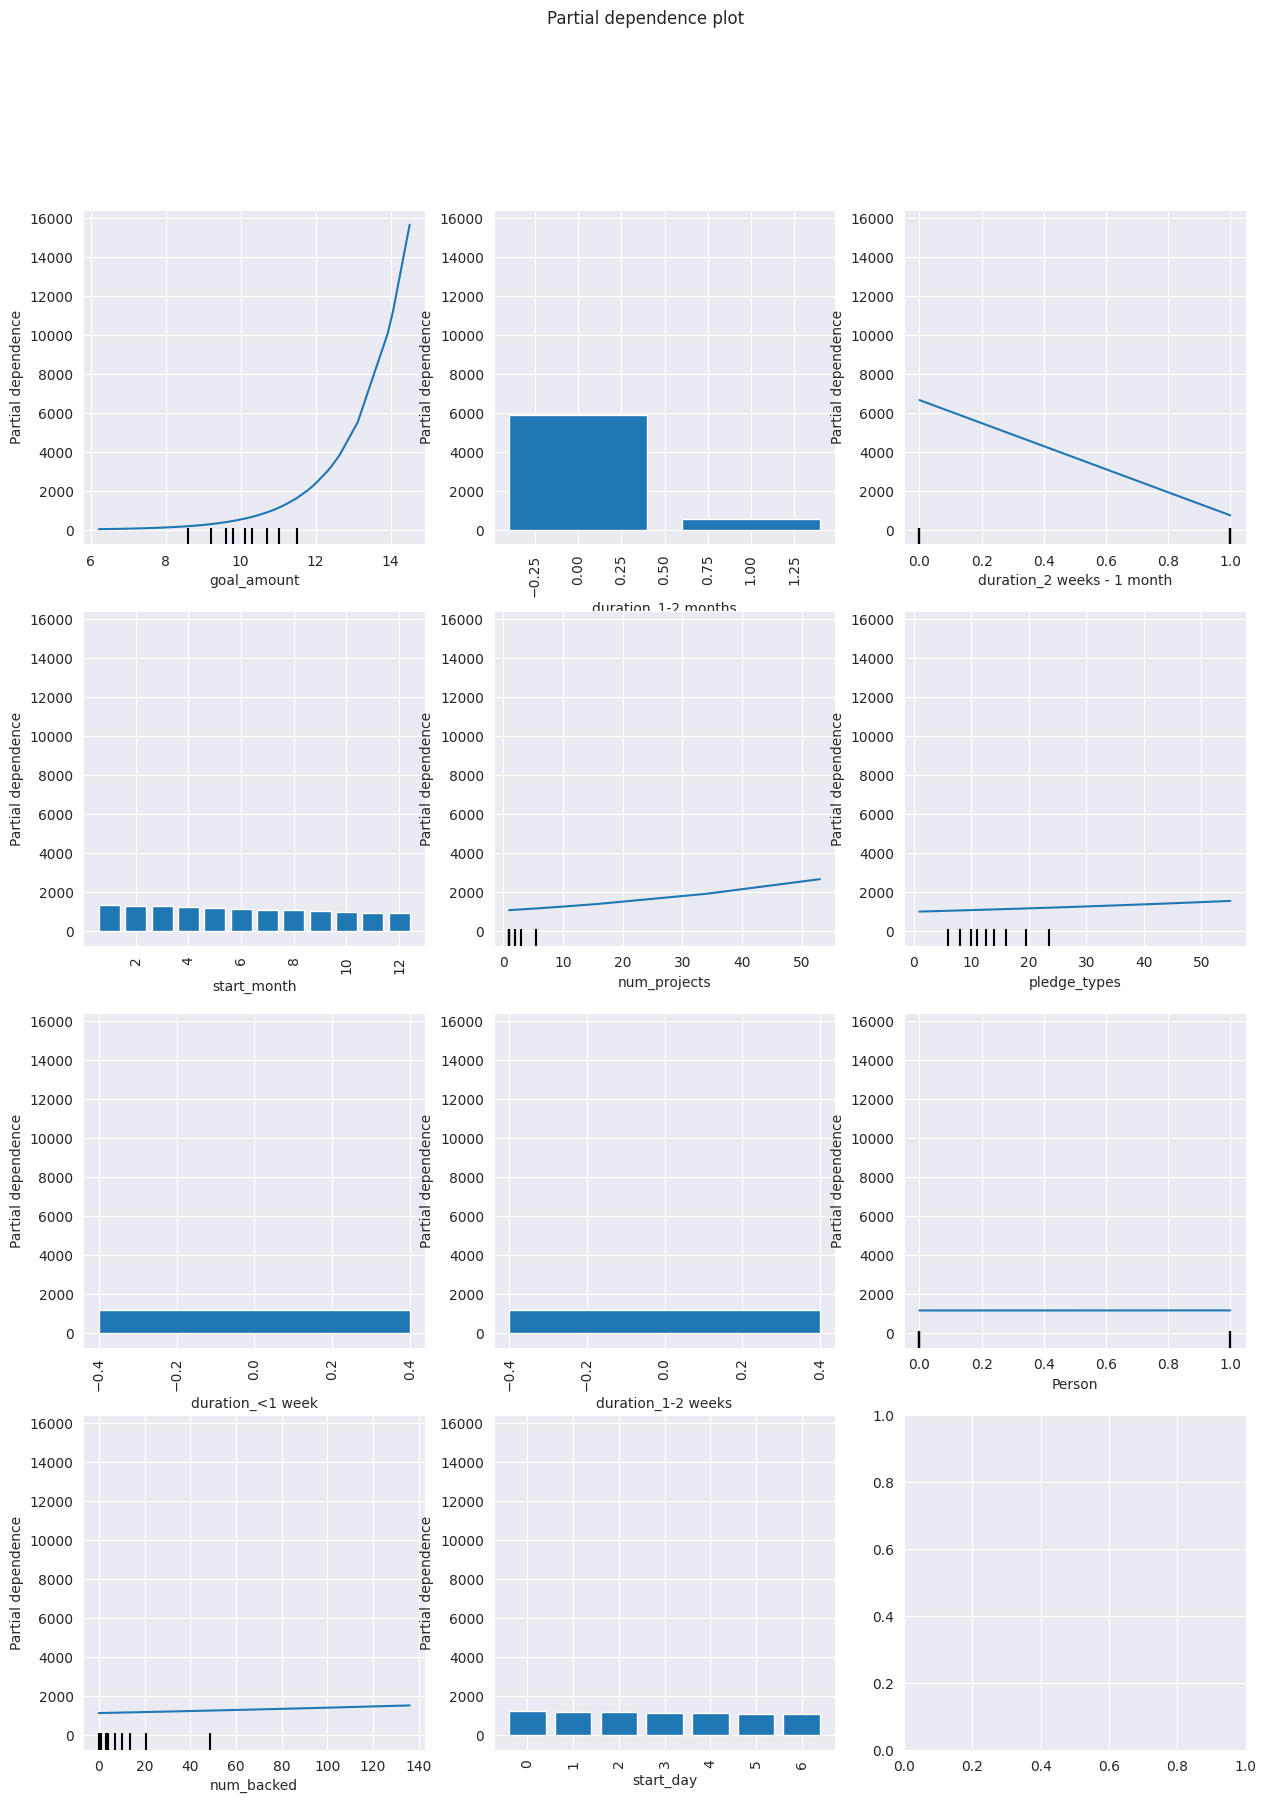

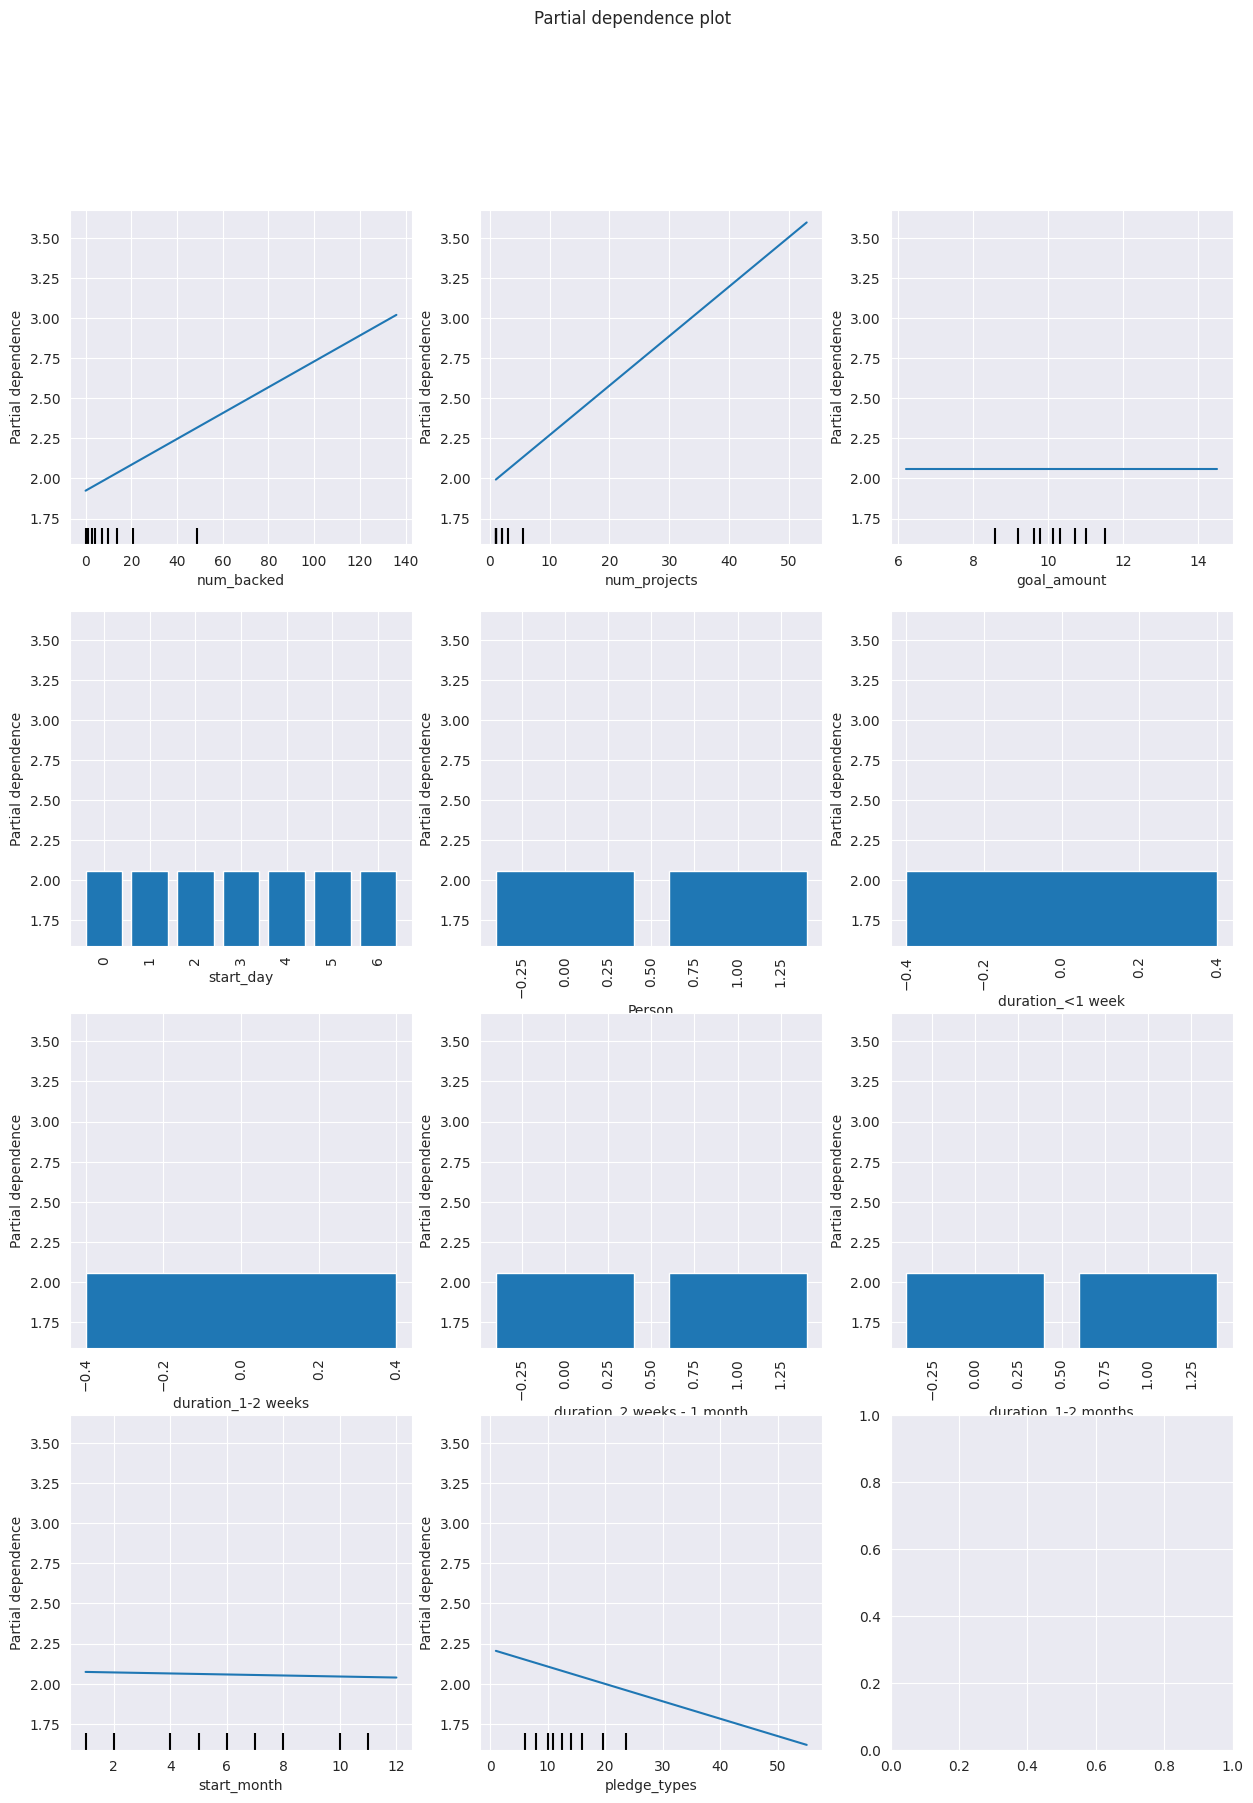

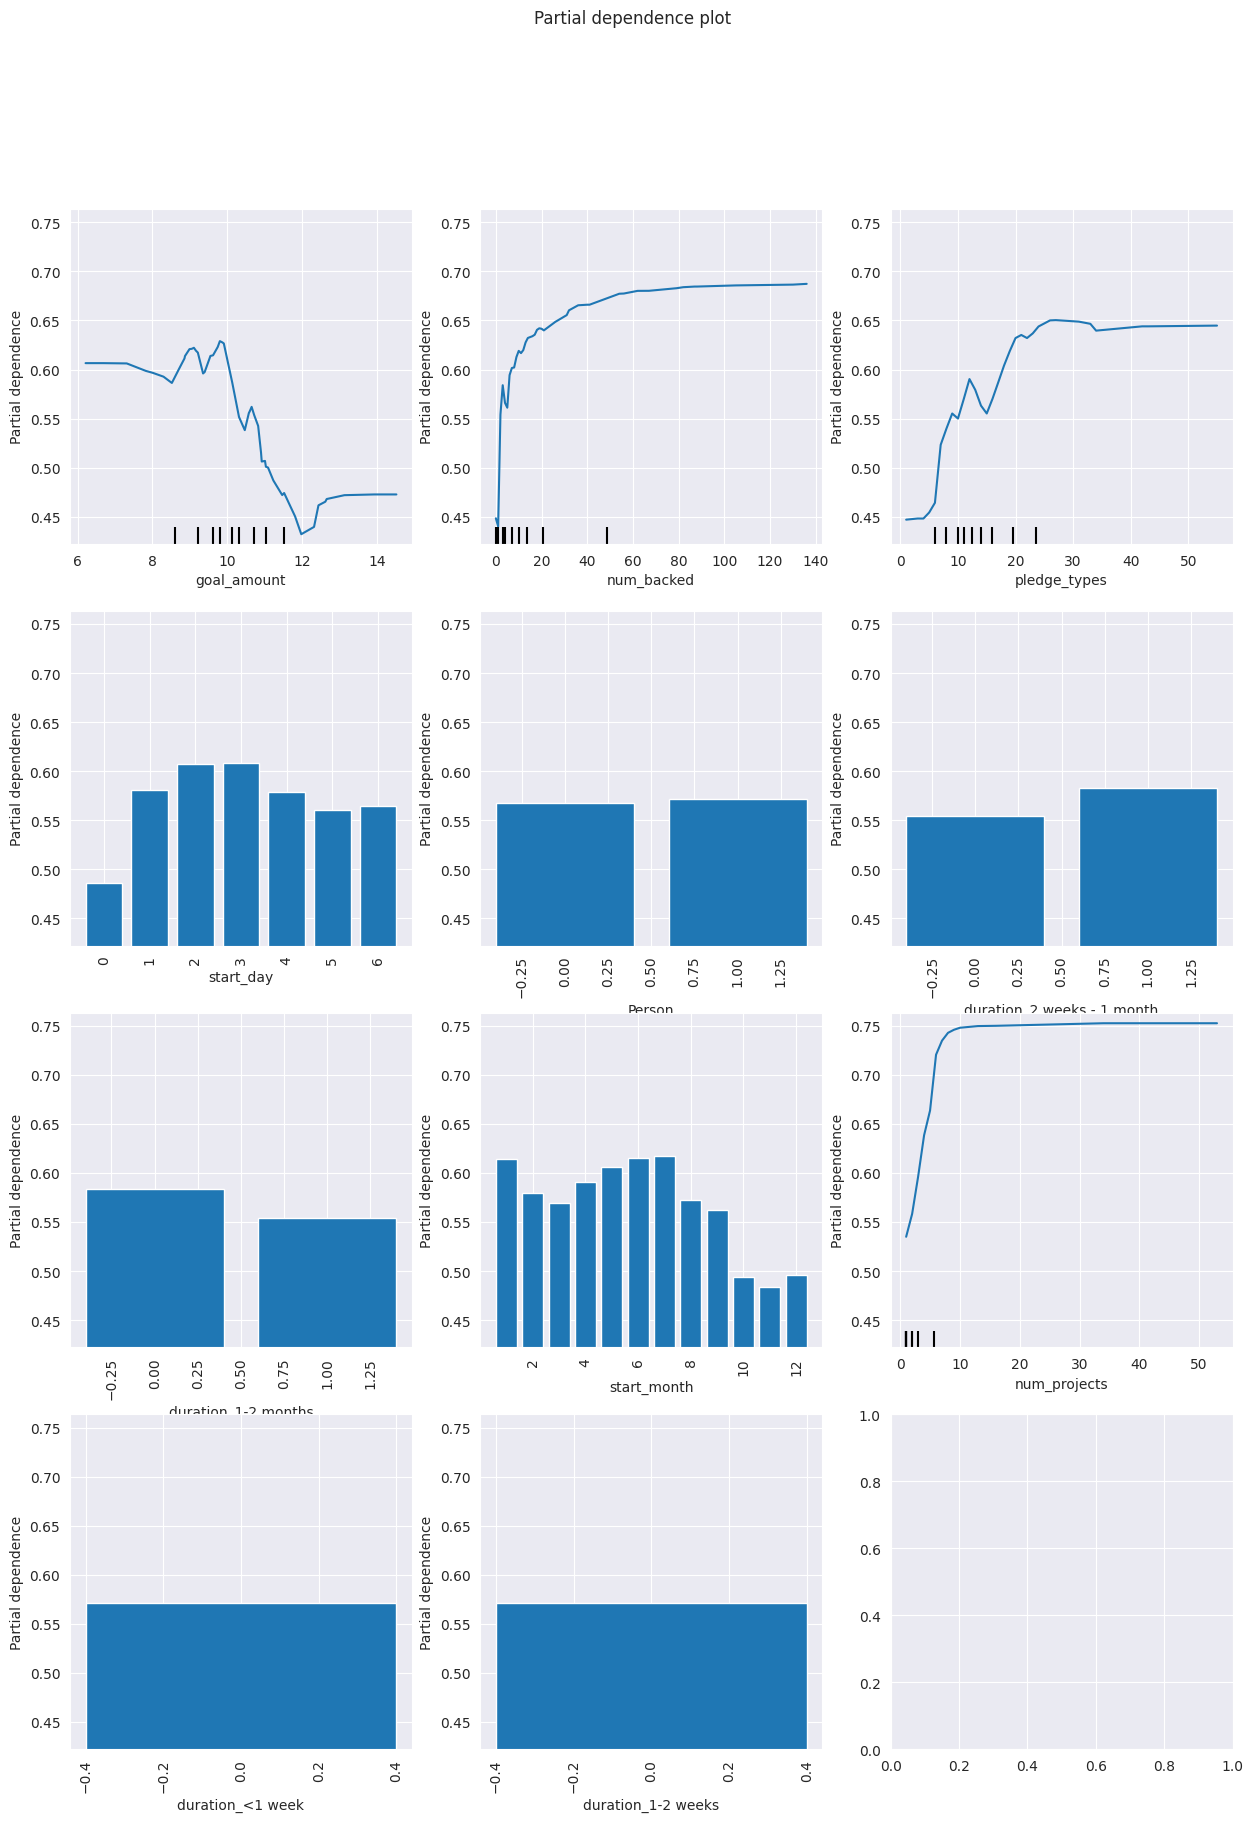

In [70]:
for model_type in [ 'backers', 'collection_ratio', 'success']:
    if model_type == 'success':
        model = success_model
        model_name = 'success'
    elif model_type == 'backers':
        model = backers_model
        model_name = 'num_backers'
    elif model_type == 'collection_ratio':
        model = collection_model
        model_name = 'collection_ratio'
    
    imp_cols = importance_df_dict[model_type].index.to_list()
    save_all_pdps(model, imp_cols, x_test, model_name, imp_cat_features[model_type])
